In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import yellowbrick
import shap
import scipy.cluster.hierarchy as shc
import optuna
import matplotlib.patches as patches
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from matplotlib.patches import Rectangle
from pywaffle import Waffle
from math import isnan
from random import sample
from numpy.random import uniform
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score, f1_score, cohen_kappa_score, classification_report
from scipy import stats
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, cohen_kappa_score, recall_score, precision_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE
from sklearn.feature_selection import mutual_info_classif
from xgboost import XGBClassifier
from pyswarms.single import GlobalBestPSO
from sklearn.preprocessing import PowerTransformer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.svm import SVC
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import StandardScaler

# Read Data

In [2]:
file_path = r"D:\Kuliah IPB\02 Kuliah\03 Semester 3\Pemodelan Klasifikasi\UAS\df_model.csv"
df_model = pd.read_csv(file_path, index_col=0)
df_model

,R105,KALORI_KAP,PROTE_KAP,LEMAK_KAP,KARBO_KAP,FOOD_LABEL,Pengeluaran_Jenis_A,Pengeluaran_Jenis_B,Pengeluaran_Jenis_C,Pengeluaran_Jenis_D,...,Pengeluaran_Jenis_M,Pengeluaran_Jenis_N,R2208A2,R2208A3,R2208A4,R2208A5,nilai_bantuan(rp),rataan_beras(rp),rataan_telur(rp),rataan_lainnya(rp)
URUT,,,,,,,,,,,,,,,,,,,,,
500001,2,2365.173362,67.130240,43.222388,352.985743,0,1,1,1,1,...,1,0,Tidak,Tidak,Ya,Tidak,150000.0,50000.0,10000.0,17500.0
500002,1,2611.639071,69.091893,30.118243,471.997686,0,1,1,1,0,...,1,1,Tidak,Tidak,Tidak,Ya,150000.0,27500.0,6500.0,8000.0
500003,2,2526.510476,68.742619,58.517619,360.456190,0,1,0,1,1,...,1,1,Tidak,Tidak,Ya,Tidak,100000.0,60000.0,15000.0,25000.0
500004,1,3655.854810,141.502615,119.460426,454.939531,0,1,1,1,1,...,1,1,Tidak,Tidak,Tidak,Tidak,0.0,0.0,0.0,0.0
500005,1,2330.987934,78.533354,53.141607,254.846110,0,1,0,1,1,...,1,1,Tidak,Tidak,Tidak,Tidak,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525886,1,2227.460536,81.321857,45.307661,306.247218,0,1,1,1,1,...,1,1,Tidak,Tidak,Tidak,Tidak,0.0,0.0,0.0,0.0
525887,1,1711.114357,68.675743,46.467657,212.155300,0,1,0,1,1,...,1,0,Tidak,Tidak,Tidak,Tidak,0.0,0.0,0.0,0.0
525888,1,1621.781673,48.896660,45.535567,215.970774,0,1,0,0,1,...,1,1,Tidak,Tidak,Tidak,Tidak,0.0,0.0,0.0,0.0


In [3]:
categorical_columns = ['R2208A2', 'R2208A3', 'R2208A4', 'R2208A5']
for col in categorical_columns:
    df_model[col] = df_model[col].map({'Tidak': 0, 'Ya': 1})
df_model[categorical_columns].head()

,R2208A2,R2208A3,R2208A4,R2208A5
URUT,,,,
500001,0,0,1,0
500002,0,0,0,1
500003,0,0,1,0
500004,0,0,0,0
500005,0,0,0,0


In [4]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25890 entries, 500001 to 525890
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   R105                 25890 non-null  int64  
 1   KALORI_KAP           25890 non-null  float64
 2   PROTE_KAP            25890 non-null  float64
 3   LEMAK_KAP            25890 non-null  float64
 4   KARBO_KAP            25890 non-null  float64
 5   FOOD_LABEL           25890 non-null  int64  
 6   Pengeluaran_Jenis_A  25890 non-null  int64  
 7   Pengeluaran_Jenis_B  25890 non-null  int64  
 8   Pengeluaran_Jenis_C  25890 non-null  int64  
 9   Pengeluaran_Jenis_D  25890 non-null  int64  
 10  Pengeluaran_Jenis_E  25890 non-null  int64  
 11  Pengeluaran_Jenis_F  25890 non-null  int64  
 12  Pengeluaran_Jenis_G  25890 non-null  int64  
 13  Pengeluaran_Jenis_H  25890 non-null  int64  
 14  Pengeluaran_Jenis_I  25890 non-null  int64  
 15  Pengeluaran_Jenis_J  25890 non-null

# Pra Proses Data

## Pencilan

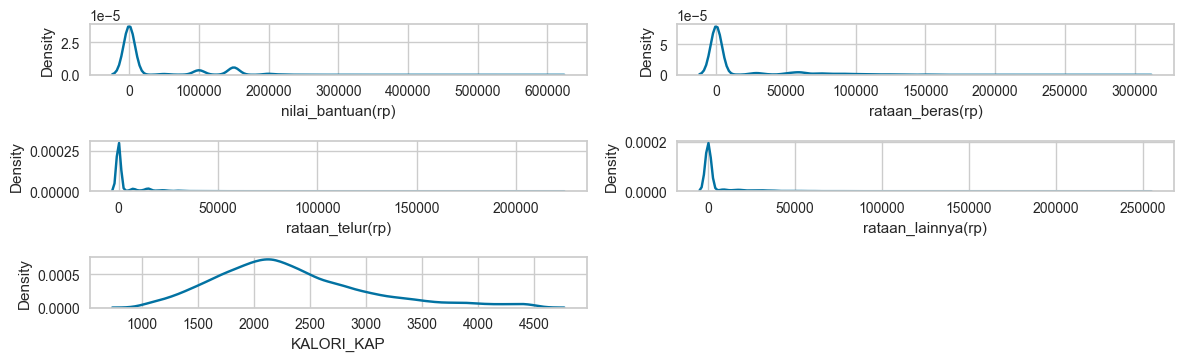

In [5]:
cols = ['nilai_bantuan(rp)', 'rataan_beras(rp)', 'rataan_telur(rp)', 'rataan_lainnya(rp)', 'KALORI_KAP']

plt.figure(figsize=(12, 8))
for i in range(len(cols)):
  plt.subplot(7, 2, i+1)
  sns.kdeplot(data=df_model, x=df_model[cols[i]])
  plt.tight_layout()

In [6]:
# Yeo-Johnson
for col in cols:
    pt = PowerTransformer(method='yeo-johnson')
    df_model[col] = pt.fit_transform(df_model[col].values.reshape(-1, 1))
    print(f"Feature: {col}, Skewness after Yeo-Johnson: {df_model[col].skew()}")

Feature: nilai_bantuan(rp), Skewness after Yeo-Johnson: 1.2751825453726524
Feature: rataan_beras(rp), Skewness after Yeo-Johnson: 1.5155835725139335
Feature: rataan_telur(rp), Skewness after Yeo-Johnson: 1.5757732441452075
Feature: rataan_lainnya(rp), Skewness after Yeo-Johnson: 1.7481814229459707
Feature: KALORI_KAP, Skewness after Yeo-Johnson: 0.00027659135064783235


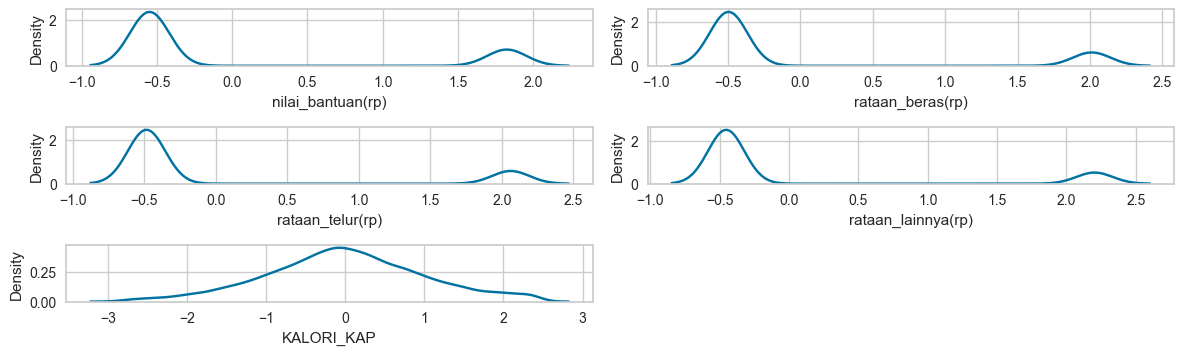

In [7]:
plt.figure(figsize=(12, 8))
for i in range(len(cols)):
  plt.subplot(7, 2, i+1)
  sns.kdeplot(data=df_model, x=df_model[cols[i]])
  plt.tight_layout()

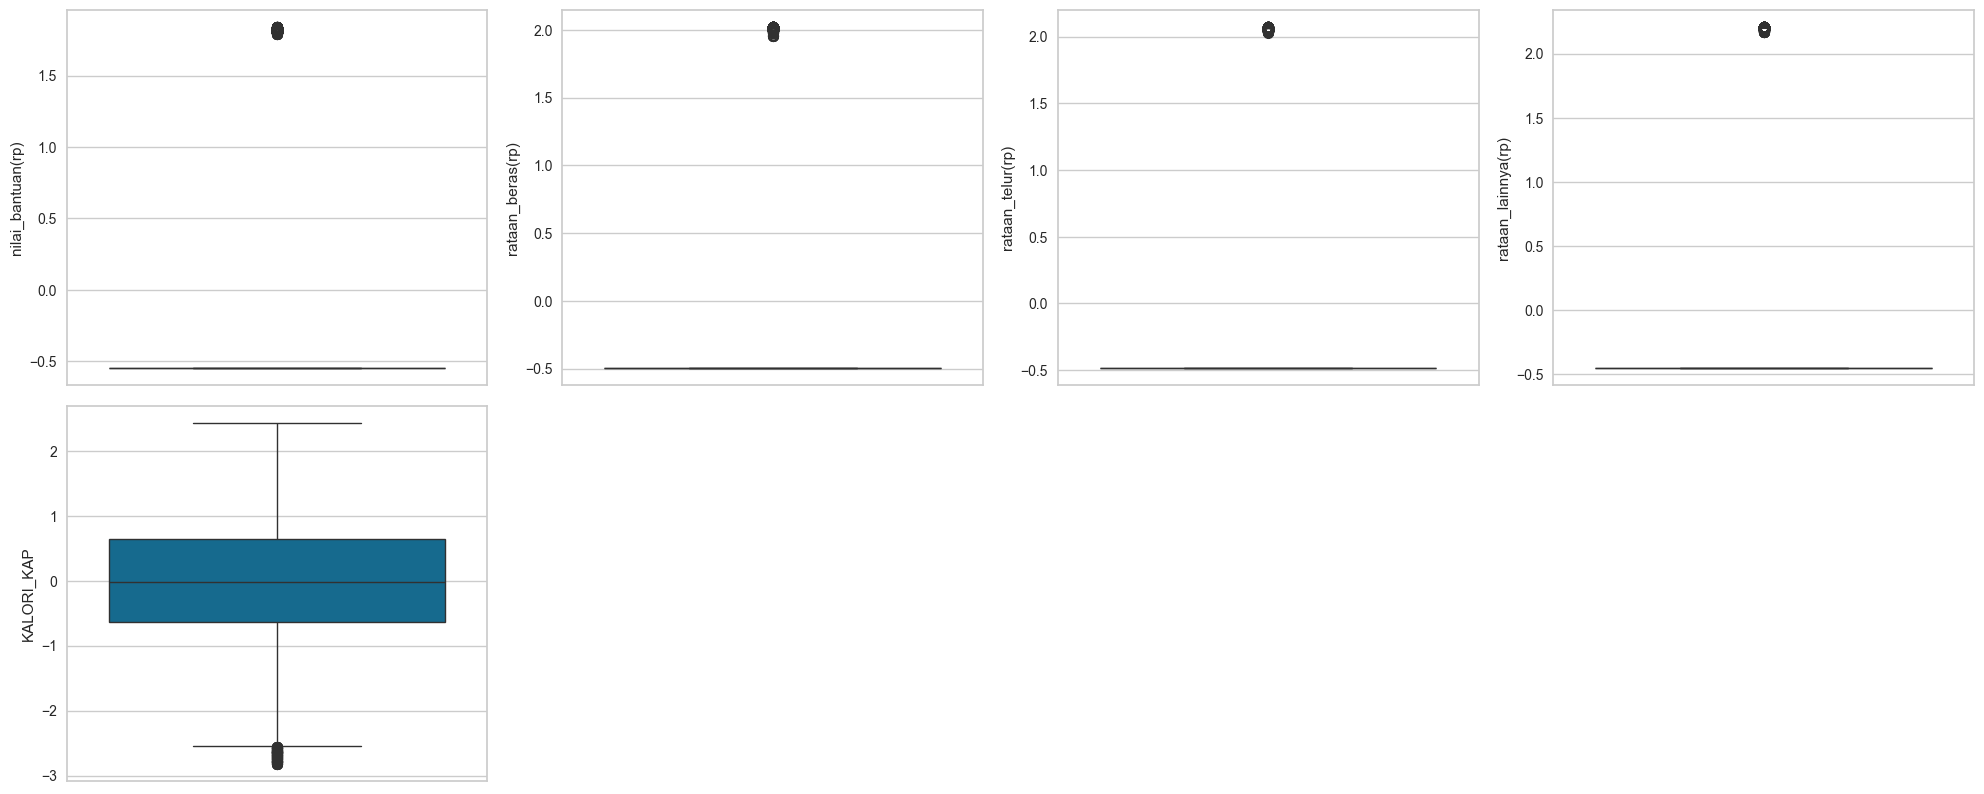

In [8]:
# Boxplot sebelum handling outlier
       
plt.figure(figsize=(20,16))
for i in range(len(cols)):
    plt.subplot(4, 4, i+1)
    sns.boxplot(y = df_model[cols[i]], orient = 'v')
    plt.tight_layout()

In [9]:
# Handling outlier dengan z-score
cols = ['nilai_bantuan(rp)', 'rataan_beras(rp)', 'rataan_telur(rp)', 'rataan_lainnya(rp)', 'KALORI_KAP']

rows_before_filt = len(df_model)
print('Jumlah Baris sebelum filter:', rows_before_filt, '\n')


filtered_entries = np.array([True] * len(df_model))

for col in cols:
    zscore = abs(stats.zscore(df_model[col]))                       # hitung absolute z-scorenya
    filtered_entries = (zscore < 2.5) & filtered_entries        # keep yang kurang dari 2.5 absolute z-scorenya
    
df_model = df_model[filtered_entries]                                    

# Total baris yang dibuang
rows_after_filt = len(df_model)
diff = round((rows_before_filt - rows_after_filt) / rows_before_filt * 100, 2)
print(f'Jumlah baris setelah memfilter outlier: {len(df_model)}')
print(f'Persentase outlier yang dibuang:', diff)

Jumlah Baris sebelum filter: 25890 

Jumlah baris setelah memfilter outlier: 25701
Persentase outlier yang dibuang: 0.73


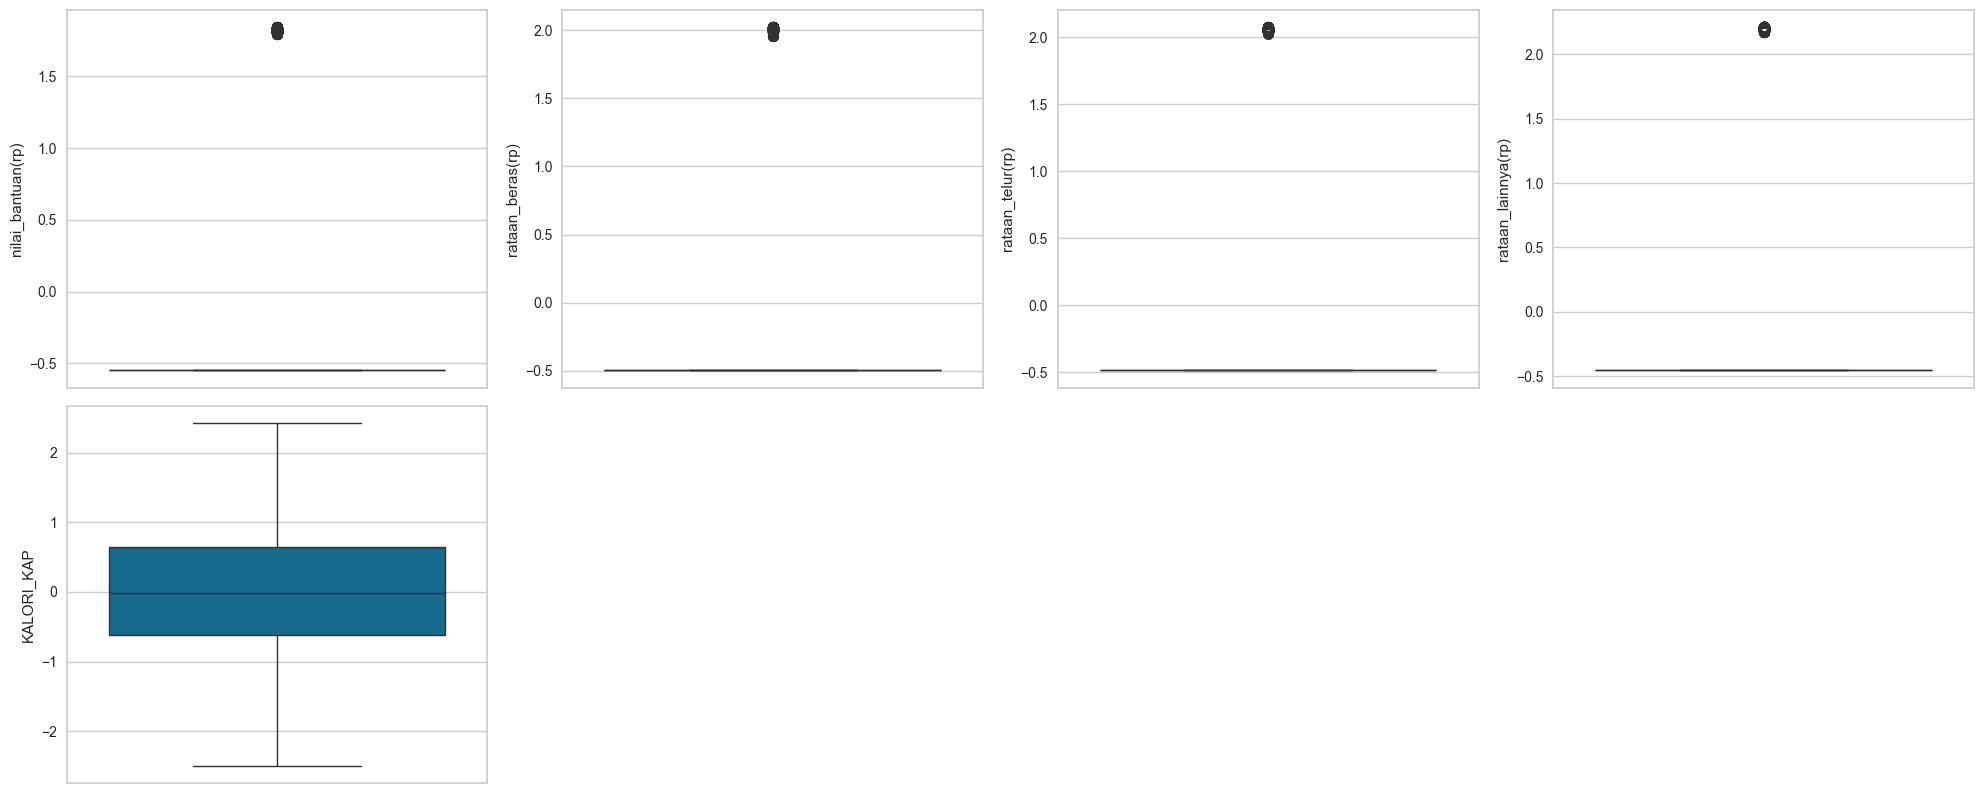

In [10]:
# Boxplot setelah handling outlier

plt.figure(figsize=(20,16))
for i in range(len(cols)):
    plt.subplot(4, 4, i+1)
    sns.boxplot(y = df_model[cols[i]], orient = 'v')
    plt.tight_layout()

# Pemodelan

In [11]:
X = df_model.drop(['FOOD_LABEL', 'PROTE_KAP', 'LEMAK_KAP', 'KARBO_KAP'], axis=1)
y = df_model['FOOD_LABEL']

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True, stratify=y, random_state=74
)

# Scaling with StandardScaler
scaler = StandardScaler()

# Fit the scaler only on the training data and transform both train and test
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Applying ADASYN for oversampling on the scaled training data
adasyn = ADASYN(random_state=86, sampling_strategy=0.5)

# Ensure input to ADASYN is a NumPy array
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_scaled.values, y_train)

# Converting back to DataFrame for consistency
X_train_adasyn = pd.DataFrame(X_train_adasyn, columns=X_train.columns)

# Keeping original copies for further use (if necessary)
X_train_adasyn_ori = X_train_adasyn.copy()
y_train_adasyn_ori = y_train_adasyn.copy()
X_test_ori = X_test_scaled.copy()
y_test_ori = y_test.copy()

In [12]:
def eval_model_holdout(model, xtrain, ytrain, xtest, ytest, plot=False):
    model.fit(xtrain, ytrain)
    y_pred_train = model.predict(xtrain)
    y_pred_test = model.predict(xtest)
    
    cm_test = confusion_matrix(ytest, y_pred_test)
    tn, fp, fn, tp = cm_test.ravel()
    sensitivity = tp / (tp + fn) 
    specificity = tn / (tn + fp)  
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0 

    print("Holdout Evaluation (Train):")
    print("Balanced Accuracy:", round(balanced_accuracy_score(ytrain, y_pred_train), 2))
    print("F1 Score:", round(f1_score(ytrain, y_pred_train), 2))
    print("Kappa:", round(cohen_kappa_score(ytrain, y_pred_train), 2))

    print("\nHoldout Evaluation (Test):")
    print("Balanced Accuracy:", round(balanced_accuracy_score(ytest, y_pred_test), 2))
    print("F1 Score:", round(f1_score(ytest, y_pred_test), 2))
    print("Kappa:", round(cohen_kappa_score(ytest, y_pred_test), 2))
    print("Sensitivity (Recall):", round(sensitivity, 2))
    print("Specificity:", round(specificity, 2))
    print("Precision:", round(precision, 2)) 

    if plot:
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Tidak Miskin', 'Miskin'], yticklabels=['Tidak Miskin', 'Miskin'])
        plt.title('Confusion Matrix Testing Data')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

In [13]:
# Fungsi untuk menghitung specificity
def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    return tn / (tn + fp)

# Scorers
specificity_scorer = make_scorer(specificity_score)
sensitivity_scorer = make_scorer(recall_score)
precision_scorer = make_scorer(precision_score)

def eval_model_CV_with_adasyn_fixed(model, X, y):
    # Pipeline for scaling, ADASYN, and SVM
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('adasyn', ADASYN(random_state=74, sampling_strategy=0.5)),
        ('model', model)
    ])
    
    # Stratified K-Fold for maintaining class proportions
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=74)
    
    # Cross-validation
    cv_results = cross_validate(
        pipeline, X, y, cv=cv, 
        scoring={
            'balanced_accuracy': 'balanced_accuracy',
            'f1': 'f1',
            'kappa': make_scorer(cohen_kappa_score),
            'sensitivity': sensitivity_scorer,
            'specificity': specificity_scorer,
            'precision': precision_scorer
        },
        return_train_score=False
    )

    # Mean metrics
    balanced_acc_scores = cv_results['test_balanced_accuracy']
    f1_scores = cv_results['test_f1']
    kappa_scores = cv_results['test_kappa']
    sensitivity_scores = cv_results['test_sensitivity']
    specificity_scores = cv_results['test_specificity']
    precision_scores = cv_results['test_precision']
    
    mean_bal_acc = round(np.mean(balanced_acc_scores), 2)
    mean_f1 = round(np.mean(f1_scores), 2)
    mean_kappa = round(np.mean(kappa_scores), 2)
    mean_sensitivity = round(np.mean(sensitivity_scores), 2)
    mean_specificity = round(np.mean(specificity_scores), 2)
    mean_precision = round(np.mean(precision_scores), 2)
    
    print('Mean Balanced Accuracy (Test):', mean_bal_acc)
    print('Mean F1 Score (Test):', mean_f1)
    print('Mean Kappa (Test):', mean_kappa)
    print('Mean Sensitivity (Test):', mean_sensitivity)
    print('Mean Specificity (Test):', mean_specificity)
    print(f'Mean Precision: {mean_precision}')

In [14]:
def mergeXy_for_CV(X1, X2, y_train, y_test):
    merge_X = pd.concat([X1, X2], ignore_index=True)
    merge_y = y_train.tolist() + y_test.tolist()
    return merge_X, merge_y

In [15]:
def objective_svm(trial):
    # Parameter tuning untuk SVM
    C = trial.suggest_float('C', 0.1, 100.0, log=True)
    gamma = trial.suggest_float('gamma', 1e-4, 1e-1, log=True)
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])

    # Pipeline untuk scaling, oversampling, dan model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('adasyn', ADASYN(random_state=86, sampling_strategy=0.5)),
        ('svm', SVC(kernel='rbf', C=C, gamma=gamma, class_weight=class_weight, random_state=74))
    ])

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=74)
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1')
    
    # Return rata-rata F1-score
    return np.mean(scores)


In [ ]:
from sklearn.model_selection import cross_val_score

study_svm = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=74))
study_svm.optimize(objective_svm, n_trials=100)

# Print hasil terbaik untuk SVM
print("Best trial for SVM:")
trial_svm = study_svm.best_trial
print("Value: {:.4f}".format(trial_svm.value))
print("Params: ")
for key, value in trial_svm.params.items():
    print("    {}: {}".format(key, value))


## Baseline Model

Holdout Evaluation (Train):
Balanced Accuracy: 0.77
F1 Score: 0.7
Kappa: 0.57

Holdout Evaluation (Test):
Balanced Accuracy: 0.73
F1 Score: 0.5
Kappa: 0.45
Sensitivity (Recall): 0.51
Specificity: 0.94
Precision: 0.5


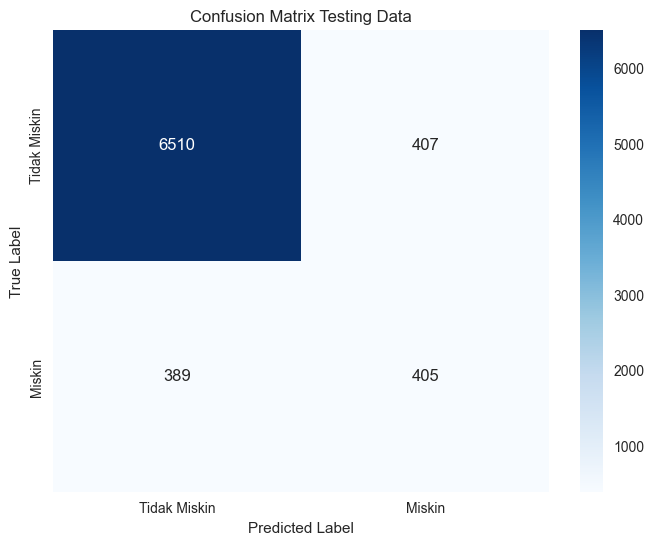

In [17]:
svm_model = SVC(kernel='rbf', C=1.31047, gamma=0.0002959, random_state=74, probability=True)
eval_model_holdout(svm_model, X_train_adasyn, y_train_adasyn, X_test, y_test, plot=True)

In [18]:
eval_model_CV_with_adasyn_fixed(svm_model,X,y)

Mean Balanced Accuracy (Test): 0.79
Mean F1 Score (Test): 0.52
Mean Kappa (Test): 0.44
Mean Sensitivity (Test): 0.7
Mean Specificity (Test): 0.88
Mean Precision: 0.41


## Seleksi Fitur

In [19]:
X_train_v3, X_test_v3 = X_train.copy(), X_test.copy()
y_train_v3, y_test_v3 = y_train.copy(), y_test.copy()

X_train_adasyn_v3 = X_train_adasyn_ori.copy()
y_train_adasyn_v3 = y_train_adasyn_ori.copy()

In [20]:
from sklearn.feature_selection import SelectKBest, f_classif

bal_acc_list = []
f1_score_list = []
kappa_list = []
k_list = []

for k in range(1, 20):
    # SelectKBest untuk seleksi fitur
    skb = SelectKBest(score_func=f_classif, k=k)
    sel_X_train = skb.fit_transform(X_train_adasyn_v3, y_train_adasyn_v3)
    sel_X_test = skb.transform(X_test_v3)

    # SVM dengan kernel RBF
    svm_model = SVC(kernel='rbf', C=1.31047, gamma=0.0002959, random_state=74, probability=True)
    svm_model.fit(sel_X_train, y_train_adasyn_v3)

    # Prediksi pada data uji
    RFE_preds = svm_model.predict(sel_X_test)

    # Evaluasi performa
    bal_acc_kbest = round(balanced_accuracy_score(y_test_v3, RFE_preds), 2)
    f1_score_kbest = round(f1_score(y_test_v3, RFE_preds), 2)
    kappa_kbest = round(cohen_kappa_score(y_test_v3, RFE_preds), 2)

    bal_acc_list.append(bal_acc_kbest)
    f1_score_list.append(f1_score_kbest)
    kappa_list.append(kappa_kbest)
    k_list.append(k)

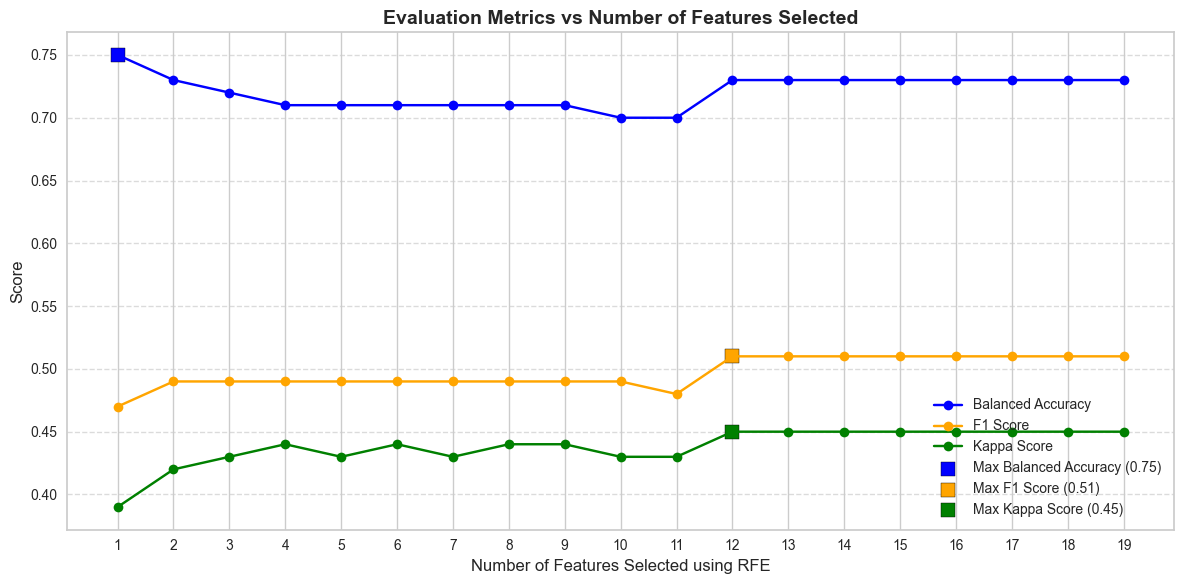

In [21]:
plt.figure(figsize=(12, 6))

plt.plot(k_list, bal_acc_list, marker='o', label='Balanced Accuracy', color='blue')
plt.plot(k_list, f1_score_list, marker='o', label='F1 Score', color='orange')
plt.plot(k_list, kappa_list, marker='o', label='Kappa Score', color='green')

max_bal_acc = max(bal_acc_list)
max_f1 = max(f1_score_list)
max_kappa = max(kappa_list)

plt.scatter(k_list[np.argmax(bal_acc_list)], max_bal_acc, color='blue', s=100, edgecolor='black', label=f'Max Balanced Accuracy ({max_bal_acc})', marker='s')
plt.scatter(k_list[np.argmax(f1_score_list)], max_f1, color='orange', s=100, edgecolor='black', label=f'Max F1 Score ({max_f1})', marker='s')
plt.scatter(k_list[np.argmax(kappa_list)], max_kappa, color='green', s=100, edgecolor='black', label=f'Max Kappa Score ({max_kappa})', marker='s')

plt.title('Evaluation Metrics vs Number of Features Selected', fontsize=14, weight='bold')
plt.xlabel('Number of Features Selected using RFE', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(k_list)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=10, loc='lower right')

plt.tight_layout()
plt.show()

In [22]:
print('Max Bal Acc:', max_bal_acc)
print('Max F1 score:', max_f1)
print('Max kappa:', max_kappa)

Max Bal Acc: 0.75
Max F1 score: 0.51
Max kappa: 0.45


In [23]:
best_k_using_bal_acc = np.argmax(bal_acc_list) + 1
best_k_using_bal_acc

1

In [24]:
best_k_using_f1 = np.argmax(f1_score_list) + 1
best_k_using_f1

12

In [25]:
selector = SelectKBest(score_func=mutual_info_classif, k=best_k_using_f1)
selector.fit(X_train_adasyn_v3, y_train_adasyn_v3)
selected_feature_mask = selector.get_support()
selected_features = X_train_adasyn_v3.columns[selected_feature_mask]
selected_features

Index(['R105', 'KALORI_KAP', 'Pengeluaran_Jenis_B', 'Pengeluaran_Jenis_D',
       'Pengeluaran_Jenis_H', 'Pengeluaran_Jenis_L', 'Pengeluaran_Jenis_N',
       'R2208A4', 'nilai_bantuan(rp)', 'rataan_beras(rp)', 'rataan_telur(rp)',
       'rataan_lainnya(rp)'],
      dtype='object')

Holdout Evaluation (Train):
Balanced Accuracy: 0.77
F1 Score: 0.69
Kappa: 0.55

Holdout Evaluation (Test):
Balanced Accuracy: 0.71
F1 Score: 0.5
Kappa: 0.44
Sensitivity (Recall): 0.48
Specificity: 0.95
Precision: 0.52


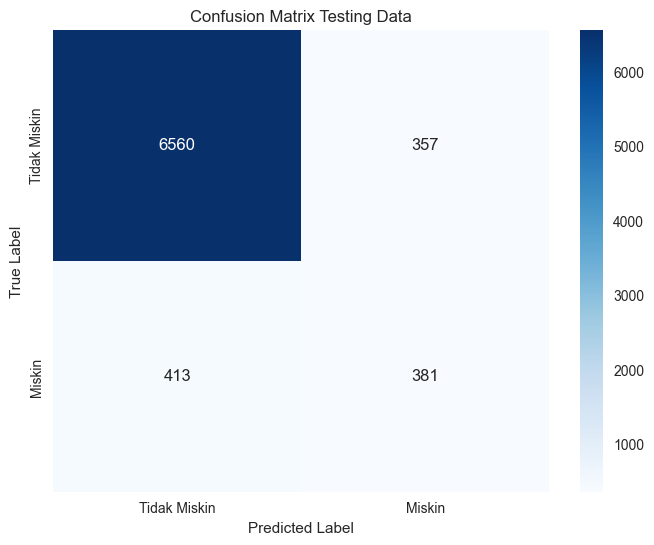

In [26]:
eval_model_holdout(svm_model, X_train_adasyn_v3[selected_features], y_train_adasyn_v3,  
                   X_test_v3[selected_features], y_test_v3,plot=True)

In [27]:
svm_pipeline_with_adasyn = Pipeline([
    ('adasyn', ADASYN(random_state=86, sampling_strategy=1)),
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=1.31, gamma=0.0002959, random_state=74, probability=True))
])

eval_model_CV_with_adasyn_fixed(svm_pipeline_with_adasyn, X[selected_features], y)

Mean Balanced Accuracy (Test): 0.8
Mean F1 Score (Test): 0.41
Mean Kappa (Test): 0.29
Mean Sensitivity (Test): 0.89
Mean Specificity (Test): 0.71
Mean Precision: 0.26


# Interpretasi

## FE - Semua Fitur

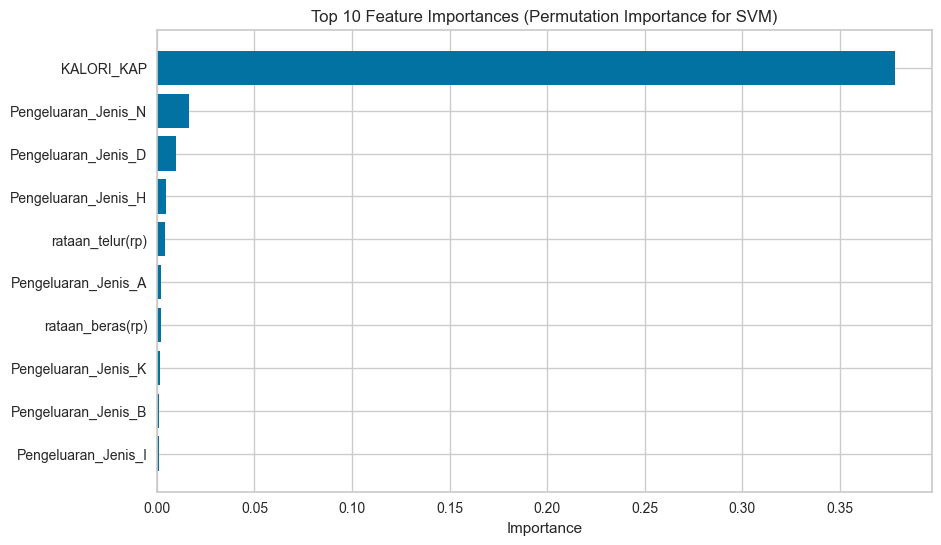

In [ ]:
from sklearn.inspection import permutation_importance

svm_model.fit(X_train_adasyn, y_train_adasyn)
result = permutation_importance(svm_model, X_test, y_test, scoring='f1', n_repeats=10, random_state=74)

# Visualisasi hasil
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': result.importances_mean
})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False).reset_index(drop=True)
top_10_features = feature_importances.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], align='center')
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances (Permutation Importance for SVM)')
plt.show()


## FE - k Fitur F1

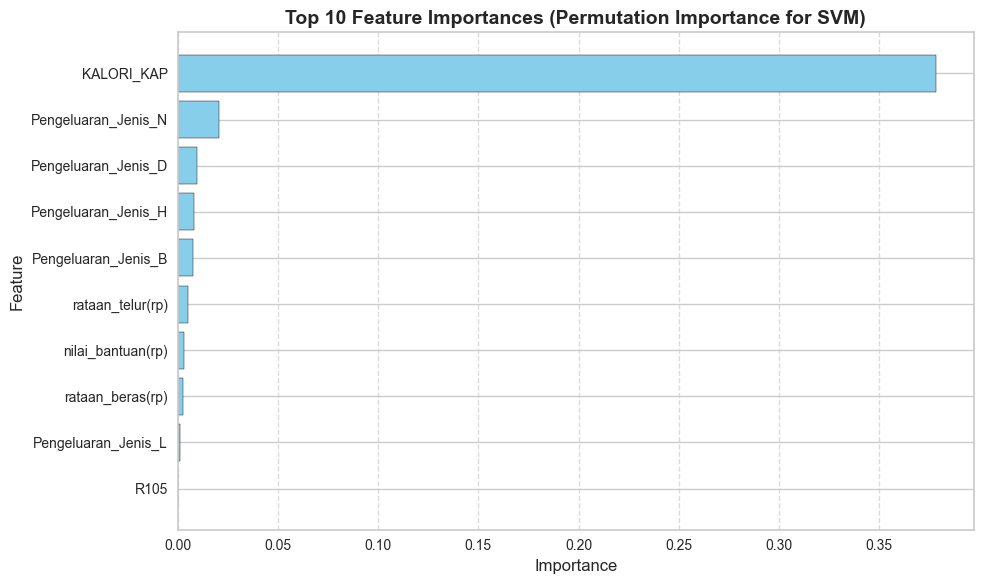

In [ ]:
# Pastikan hanya menggunakan fitur terseleksi
X_train_selected = X_train_adasyn_v3[selected_features]
X_test_selected = X_test_v3[selected_features]

# Latih model SVM pada data dengan fitur terseleksi
svm_model.fit(X_train_selected, y_train_adasyn_v3)

# Hitung permutation importance
result = permutation_importance(
    svm_model, X_test_selected, y_test_v3,
    scoring='f1', n_repeats=10, random_state=74
)

# Buat DataFrame untuk importance, menggunakan fitur terseleksi
feature_importances = pd.DataFrame({
    'Feature': selected_features,  # Fitur terseleksi
    'Importance': result.importances_mean  # Nilai rata-rata importance
})

# Urutkan fitur berdasarkan nilai importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Pilih 10 fitur teratas
top_10_features = feature_importances.head(10)

# Visualisasikan fitur terpenting
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], align='center', color='skyblue', edgecolor='black')
plt.gca().invert_yaxis()  # Membalik urutan y untuk menempatkan fitur penting di atas
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 10 Feature Importances (Permutation Importance for SVM)', fontsize=14, weight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()